In [24]:
## Make sure this tool Path Matches the path for YOUR computer
toolPath = r'/Users/koshnick/Box Sync/UCD_ECO_coding/MnV-Tool/src'

import sys
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
sys.path.append(toolPath)
import mnv

pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 500)

print(mnv.version)  # Last updated for mnv v1.6.2

Version 1.6.2


### Local Data Loading

In [2]:
filePath = 'data/pes kbtu.xlsx'
data = pd.read_excel(filePath, header=0, index_col=0, parse_dates=True, infer_datetime_format=True)
print(data.columns)

Index(['PES_ChilledWater_Demand_kBtu', 'PES_Electricity_Demand_kBtu', 'PES_Steam_Demand_kBtu'], dtype='object')


### PI Data Loading

In [26]:
tags = mnv.pi.search_by_point('*ghausi*kbtu*')[0]
# tags += pi.search_by_point('*shields*kbtu*')[0]

# print(tags)

#### Pull tags

In [ ]:
startDate = '2013-01-01'
endDate = '2018-03-01'
interval = '1 hour' #Can be "minute" "hour" "day"
calculation = 'calculated' # Redundant?

# data = mnv.pi.get_stream_by_point(tags, start=startDate, end=endDate, interval=interval, calculation=calculation)

# Data Section

Timedelta: "0 days 01:00:00" is 60.0 min
Q(75%): 1857.14 Q(25%): 739.21
IQR value is 1117.93
IQRupper 5210.95 ; IQRlower -2614.6
Ceiling adjusted by IQR - Now 5210.95

OAT being loaded from master file C:\Users\koshnick\Box Sync\UCD_ECO_coding\MnV-Tool\src\OATmaster.csv


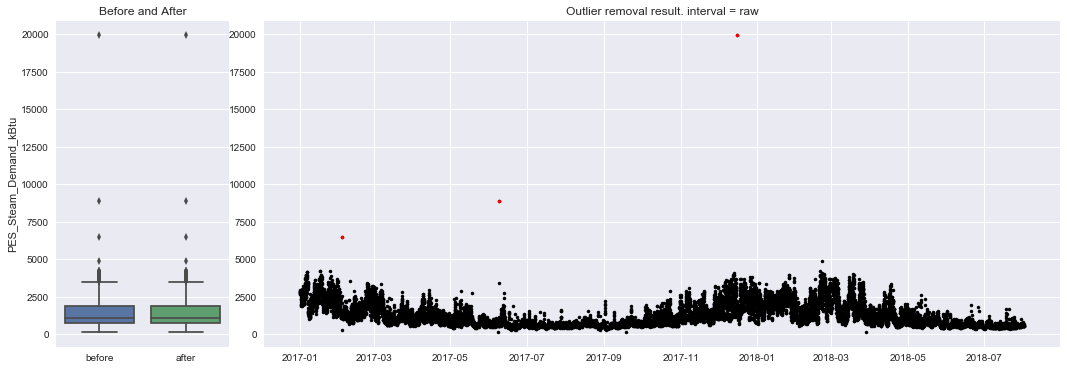

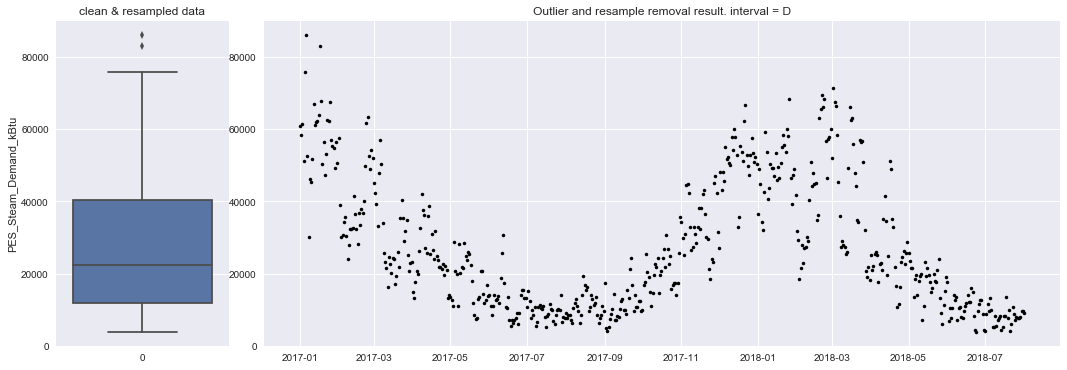

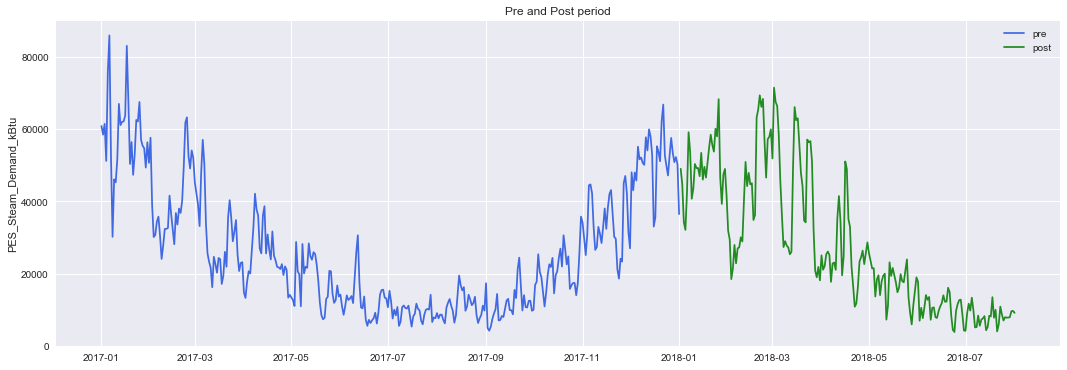

In [14]:
dataParams = {'column': 'PES_Steam_Demand_kBtu',
              'IQRmult' : 3.0,
              'IQR' : True,
              'floor': -1,
#               'ceiling': 40000,
              'resampleRate' : 'D', #'D' for daily 'H' for hourly
              'OATsource' : 'file', #'self' or 'file' or 'pi' (aiTIT4045)
              'OATname' : 'OAT', #Name of OAT column if OATsource is 'self'} #only needed with sliceType : 'ranges'
              'sliceType' : 'ranges', #half, middate, ranges
              'midDate' : '2017-01-01', #only needed with sliceType : 'middate'
              'dateRanges' : ['2017-01-01','2018-01-01','2018-01-02','2018-08-01'], #only needed with sliceType : 'ranges'
             }

dk = mnv.data_keeper(data, dataParams)
dk.default_clean()

# Plots
dk._outlier_plot()
dk._resampled_plot()
dk._pre_post_plot()

# Many Linear Models

Entering run_all_linear()...

... run_all_linear() complete
        AIC       AR2        R2     cvrmse postDiff                                  var
3   5377.32   0.98133  0.982229  0.0901085  47797.9    CDH + HDH + C(month) + C(weekday)
27  5379.26  0.979603  0.980514  0.0894885  51079.6          HDH + C(month) + C(weekday)
15  5381.72  0.980728  0.981656  0.0893142  79310.6   CDH2 + HDH + C(month) + C(weekday)
26  5407.45  0.978161  0.978311  0.0954082  97443.4                     HDH + C(weekday)
14  5409.85  0.978807  0.979025  0.0937151  89806.6              CDH2 + HDH + C(weekday)
2   5429.67  0.977346  0.977579  0.0986882  80291.8               CDH + HDH + C(weekday)
25  5474.09  0.974736  0.975778   0.104686  33365.4                       HDH + C(month)
1   5490.71  0.973395  0.974583   0.108455    95431                 CDH + HDH + C(month)
13  5509.89  0.971431  0.972707   0.112755  94605.1                CDH2 + HDH + C(month)
19  5520.11   0.96845  0.969968   0.115732  90134.

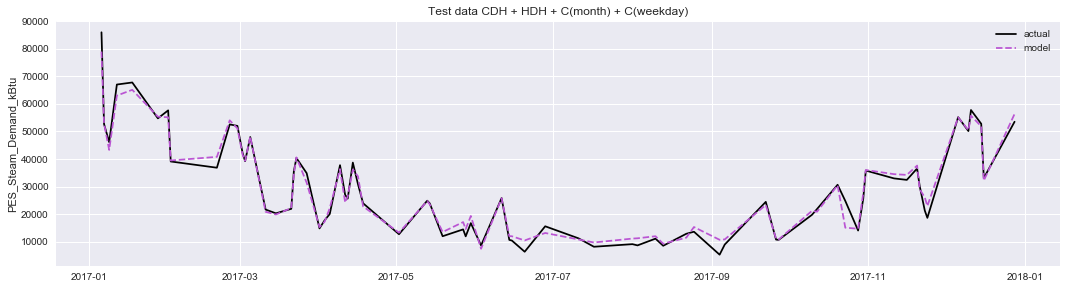

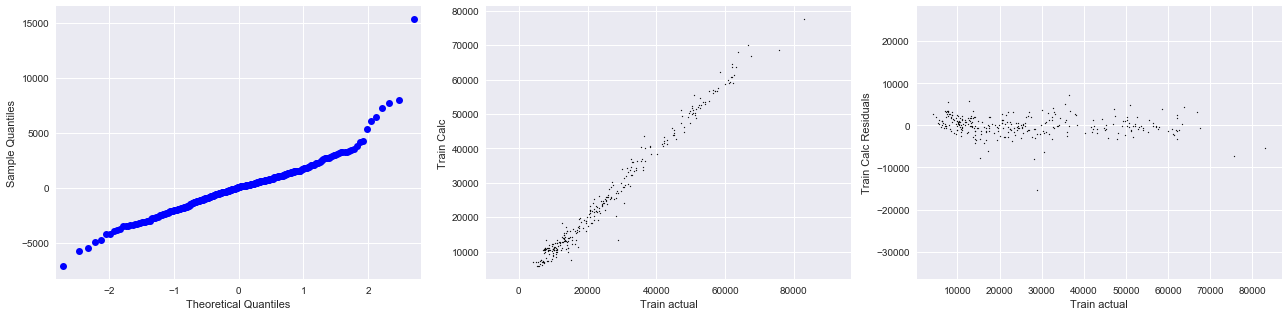

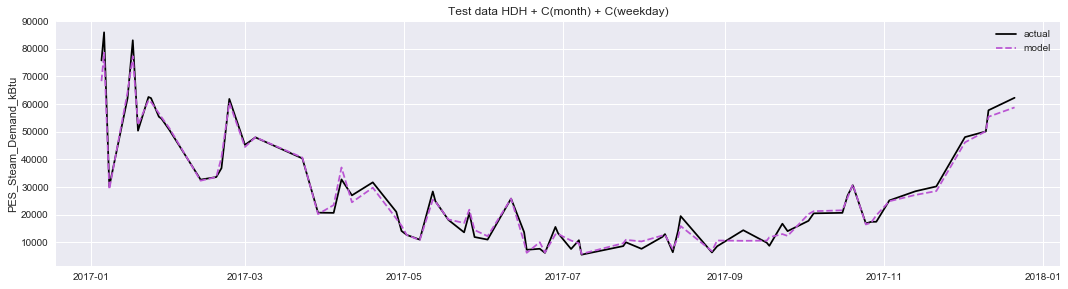

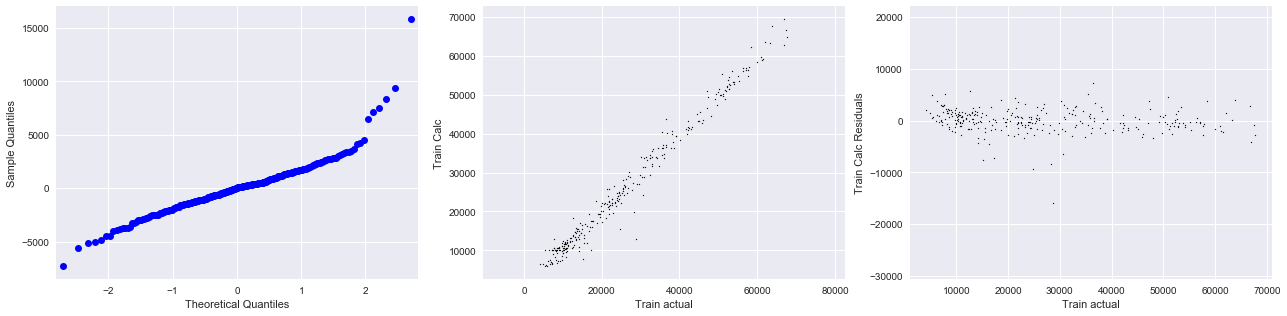

In [18]:
modelParams = {'var': ['CDH', 'HDH', 'month', 'hour', 'weekday'],
               'testTrainSplit': 'random',
               'randomState': None,  #Good idea to use a seed value so folds consitent between runs
               'testSize': 0.20,
               'commodityRate': 0.0651,
               'varPermuteList': ['', 'C(month)', 'C(weekday)']
              }

allmod = mnv.many_ols(dk.pre, dk.post, modelParams)
allmod.run_all_linear()

print(allmod.statsPool[0:15])  # Display top stats
allmod.plot_pool(2)  # Visualize top models

# Single Linear Model

               VIF
const    61.061655
HDH       6.171666
month_7   5.264353
month_8   5.128234

Kfold
        AR2           mse  pct. of mean
3  0.982668  4.946182e+06     90.242632
1  0.983382  5.005790e+06     91.330174
2  0.981343  5.636935e+06    102.845357
4  0.981176  5.882158e+06    107.319413
0  0.980197  5.933845e+06    108.262436


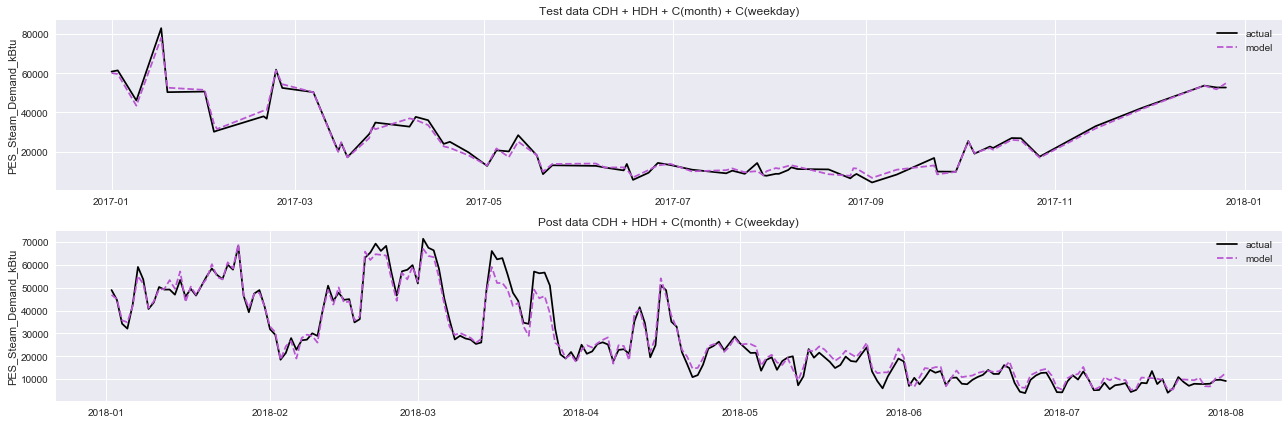

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     PES_Steam_Demand_kBtu   R-squared:                       0.981
Model:                               OLS   Adj. R-squared:                  0.980
Method:                    Least Squares   F-statistic:                     1030.
Date:                   Thu, 20 Sep 2018   Prob (F-statistic):          1.38e-229
Time:                           16:33:03   Log-Likelihood:                -2683.7
No. Observations:                    292   AIC:                             5397.
Df Residuals:                        277   BIC:                             5452.
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.024e+04   1102.473      9.288      0.000    8069.902    1.24e+04
C(month)[T.2]   -1710.3473    796.637     -2.147      0.033   -3278.579    -142.115
C(month)[T.3]   -1199.5012    884.348     -1.356      0.176   -2940.397     541.395
C(month)[T.4]   -1973.2875    946.267     -2.085      0.038   -3836.076    -110.499
C(month)[T.5]   -2359.6358   1036.843     -2.276      0.024   -4400.729    -318.543
C(month)[T.6]   -4696.8275   1111.314     -4.226      0.000   -6884.521   -2509.134
C(month)[T.7]   -5483.8120   1183.439     -4.634      0.000   -7813.488   -3154.136
C(month)[T.8]   -3698.3850   1158.814     -3.192      0.002   -5979.586   -1417.184
C(month)[T.9]   -4479.3825   1119.027     -4.003      0.000   -6682.260   -2276.505
C(month)[T.10]  -1795.2707   1011.892     -1.774      0.077   -3787.247     196.705
C(month)[T.11]  -2125.6527    821.151     -2.589      0.010   -3742.141    -509.164
C(month)[T.12]   -725.3538    676.194     -1.073      0.284   -2056.486     605.778
C(weekday)[T.1]  3971.5172    317.294     12.517      0.000    3346.903    4596.132
CDH                 4.0391      3.511      1.150      0.251      -2.872      10.950
HDH               118.4925      2.605     45.479      0.000     113.363     123.621
==============================================================================
Omnibus:                      110.347   Durbin-Watson:                   1.558
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              785.996
Skew:                           1.349   Prob(JB):                    2.10e-171
Kurtosis:                      10.571   Cond. No.                     4.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# Set the modelParam "var" to the 'best' model from run_all_linear()
modelParams['var'] = allmod.statsPool.iloc[0]['var']

mod = mnv.ols_model(dk.pre, dk.post, modelParams)
mod.calculate_kfold()
mod.calculate_vif()

print(mod.vif[mod.vif['VIF'] > 5])

print('\nKfold')
print(mod.kfoldStats)

mod.model_plot()
plt.show() # Show plot before Stats summary
mod.Fit.summary()

### Savings

Dollar Difference = $3416.1


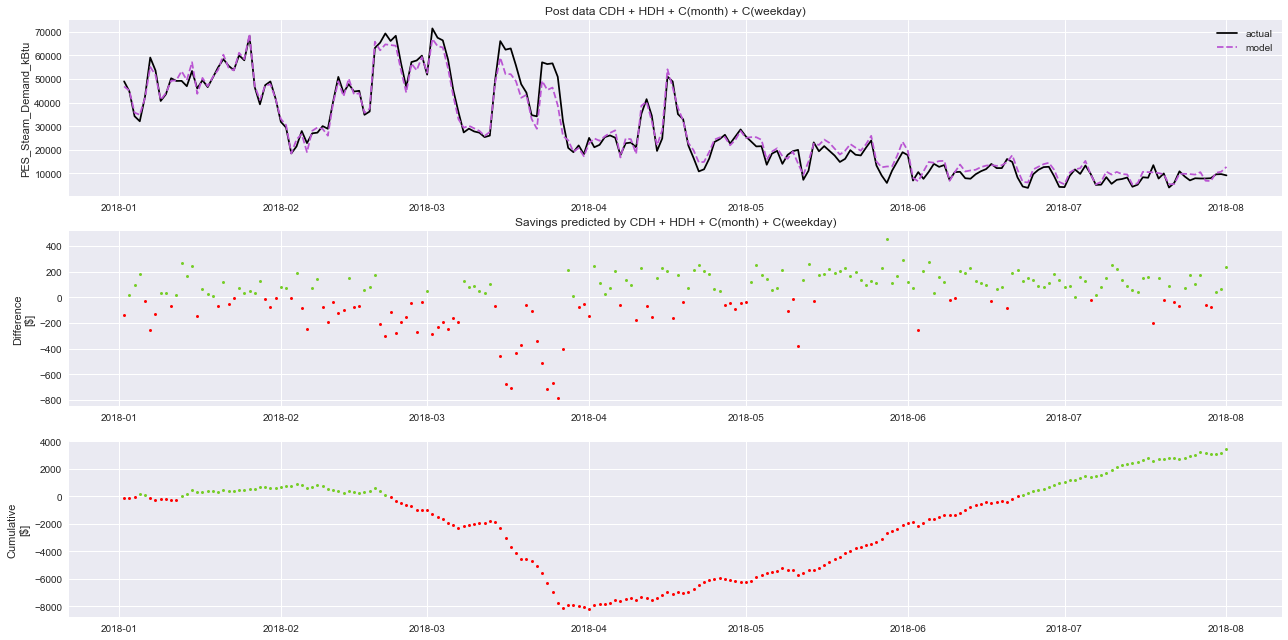

In [21]:
print("Dollar Difference = $" +str(round(mod.postDiffSum * mod.params.commodityRate, 1)))
mod.savings_plot(yaxis='dollars')

### TMY


Future_TMY                                        1 / 1    
OAT supplied with df
TMY estimated savings = $11814.5
            Actual TMY prediction  Combined      Start     Middle        End
Last FY   -8180.15            NaN   -8180.0 2018-01-02        NaT 2018-04-01
This FY    11449.2        7025.69   18475.0 2018-04-01 2018-08-01 2019-04-01
Last Year      NaN            NaN       0.0        NaT        NaT        NaT
This Year  3416.12        7025.69   10442.0 2018-01-02 2018-08-01 2019-01-02
Total      3416.12          247.9    3664.0 2018-01-02 2018-08-01 2018-08-01


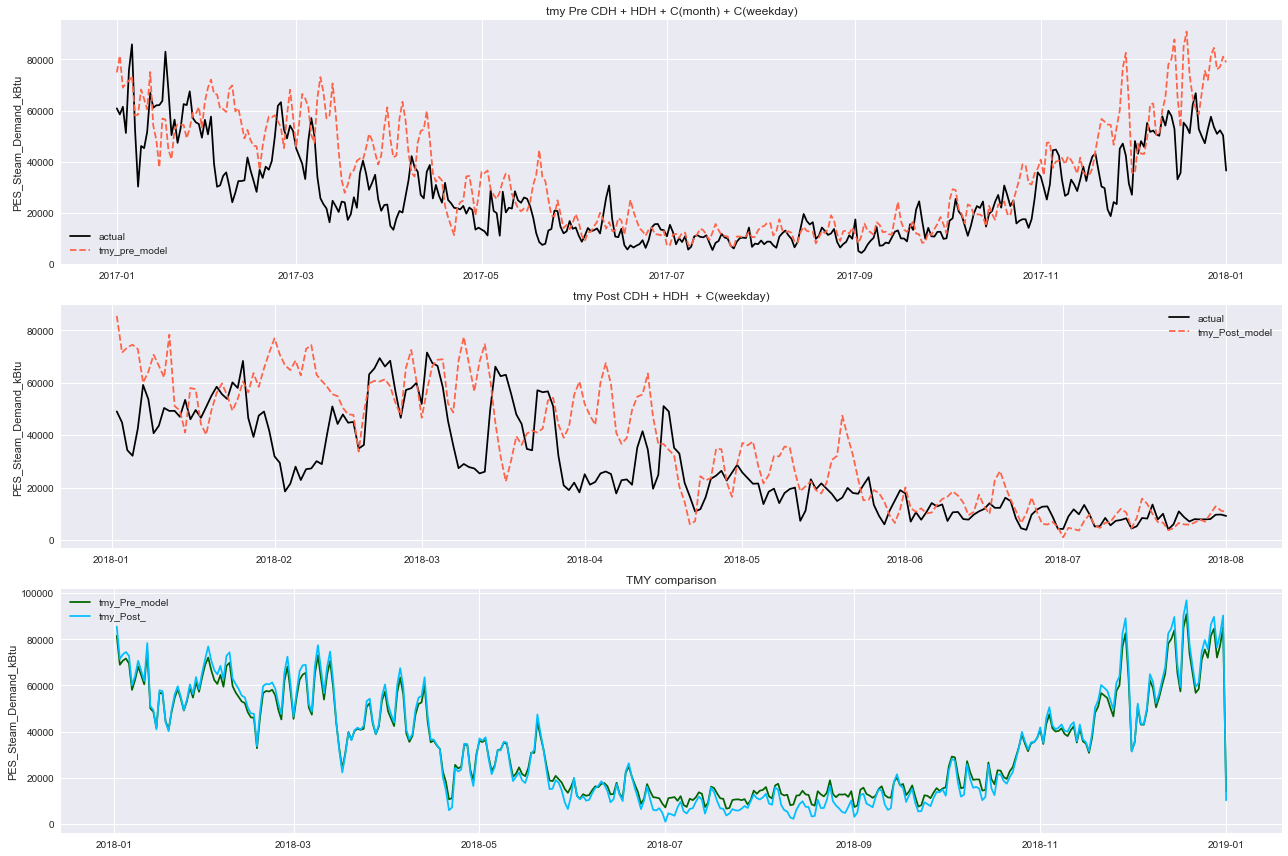

In [22]:
mod.generate_savings_summary()
mod.calculate_F_uncertainty()
mod.plot_tmy_comparison()

print("TMY estimated savings = $" + str(round(mod.data['tmyDiff'].cumsum()[-1] * mod.params.commodityRate, 1)))

print(mod.savingsSummary)

### Creating an Archive

In [23]:
## Only run this section when you're confident in the model and wish to save it
mnv.create_archive(dk, mod, saveFigs=False, copyRemodel=True)
